In [1]:
import xarray
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
from tqdm import tqdm
from preprocess.sza import solarzenithangle
from utils.etc import benchmark
from dask.distributed import Client
import shutil, gc
import os

In [2]:
client = Client()

In [3]:
folder = '/scratch/snx3000/kschuurm/DATA/IEA_PVPS/'


index = xarray.open_dataset(folder + 'index.nc')

extent = [-8, 29, 29, 62]

index = index.where((index.longitude > extent[0]) &  
                    (index.longitude < extent[1]) &
                    (index.latitude > extent[2]) &
                    (index.latitude < extent[3]), drop=True)

In [4]:
folder = '/scratch/snx3000/kschuurm/DATA/IEA_PVPS/'
CAB = xarray.open_dataset(folder + 'IEA_PVPS-CAB.nc')
CAB

<xarray.Dataset>
Dimensions:       (time: 2628937)
Coordinates:
    latitude      float32 ...
    longitude     float32 ...
    elevation     float32 ...
  * time          (time) datetime64[ns] 2015-01-01 ... 2019-12-31T15:36:00
Data variables: (12/26)
    station_name  <U3 ...
    crs           float64 ...
    GHI           (time) float32 ...
    DIF           (time) float32 ...
    DNI           (time) float32 ...
    GHIcalc       (time) float32 ...
    ...            ...
    flagKnKt      (time) float64 ...
    flagKhighSZA  (time) float64 ...
    flagKlowSZA   (time) float64 ...
    flagTracker   (time) float64 ...
    flagManual    (time) float64 ...
    QC            (time) float64 ...
Attributes: (12/35)
    id:                        IEA_PVPS-CAB
    title:                     Timeseries of Validation dataset of the task 1...
    description:               Reference data used for the validation work in...
    featureType:               timeSeries
    cdm_data_type:             timeSeries
    Conventions:               CF-1.9,ACDD-1.3
    ...                        ...
    network_id:                IEA_PVPS
    station_id:                CAB
    station_uid:               CAB
    network_region:            Global
    station_city:              Cabauw
    station_country:           Netherlands

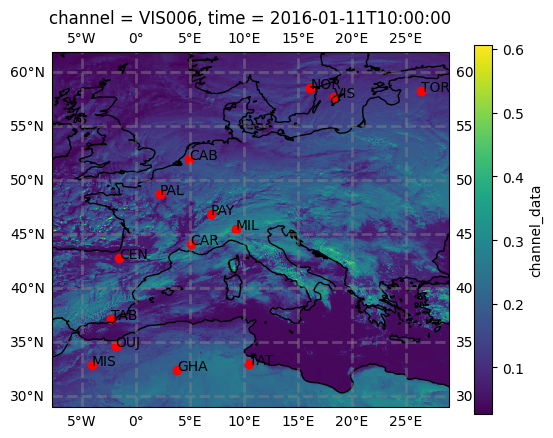

In [5]:
hrseviri = xarray.open_zarr('/scratch/snx3000/kschuurm/ZARR/SEVIRI_new.zarr')

proj = ccrs.PlateCarree()

fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=proj))

gl = axis.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

axis.coastlines()

lat = index.latitude.values
lon = index.longitude.values
name = index.station_name.values
axis.scatter(x=lon, y=lat, c='r')
for i, txt in enumerate(name):
    axis.annotate(txt, (lon[i], lat[i]))

hrseviri.channel_data.sel(channel='VIS006').isel(time = 1000).plot.imshow(ax=axis, transform = proj)



In [4]:
def create_collocated_zarr_old(station_name, patch_size=31, time_window=12):
    
    SAVE_PATH = f'/scratch/snx3000/kschuurm/ZARR/{station_name}/'
    
    station = xarray.open_dataset(f'/scratch/snx3000/kschuurm/DATA/IEA_PVPS/IEA_PVPS-{station_name}.nc')
    
    # locate the collocated point of seviri with the station
    lat = stations.sel(station_name=station_name).latitude.data
    lon = stations.sel(station_name=station_name).longitude.values
    ilat = (np.abs(hrseviri.y - lat)).argmin().values
    ilon = (np.abs(hrseviri.x - lon)).argmin().values

    hpatch = int(np.floor(patch_size/2))

    station_slice = hrseviri.isel(y=slice(ilat-hpatch, ilat + hpatch +1), x=slice(ilon-hpatch, ilon + hpatch +1))
    station_slice = station_slice.chunk({'time':10000}) 

    for var in station_slice:
        station_slice[var].encoding['chunks'] = {'time':10000}
    
    # Write the subset to a zarr dataset before performing the next operations
    station_slice.to_zarr(SAVE_PATH + f'SEVIRI_{station_name}.zarr', mode='w')   
    station_slice = xarray.open_zarr(SAVE_PATH + f'SEVIRI_{station_name}.zarr')
    
    # drop time slices with missing information
    station_slice = station_slice.dropna(dim='time')
    
    rolling = station \
        .GHI.rolling(time=time_window,center=False) \
        .mean().dropna(dim='time')
    # rolling average of X minutes (seviri takes X min to create an image, RSS=5min, normal full disk 12min)
    # mean becomes a nan if a single nan value is encountered in GHI
    
    # mean index is the right most index -> convert to left most index to relate to hrseviri
    rolling['time'] = rolling['time'] - np.timedelta64(time_window, 'm')
        
    print('time slices SEVIRI (not nan):', len(station_slice.time.values)) #hrseviri should be full minute 
    timenotnan = set(rolling.time.values).intersection(set(station_slice.time.values))

    timenotnan = np.sort(np.array(list(timenotnan)))
    print('intersecting station with seviri slices:', len(timenotnan))
    
    np.save( SAVE_PATH + 'timeidxnotnan.npy', timenotnan)
    
    print()
    print(f'        STATION {station_name} DONE         ')
    print()

In [5]:
def create_collocated_zarr(hrseviri, station_name, time_window=15, patch_size=31):
    
    station = xarray.open_dataset(f'/scratch/snx3000/kschuurm/DATA/IEA_PVPS/IEA_PVPS-{station_name}.nc').load()
    
    station = station.drop(['station_name'])
    with benchmark('where'):
        invalid = xarray.where((station.GHI > 1500), True, False)
        invalid2 = xarray.where(station.QC.isnull() != True, True, False)
        station['GHI'][invalid] = np.nan
        station['GHI'][invalid2] = np.nan
    
    rolling = station.rolling(time=time_window,center=False) \
        .mean().dropna(dim='time', subset=['GHI'])
    
    rolling['time'] = rolling['time'] - np.timedelta64(time_window, 'm')
    
    lat = station.latitude.values
    lon = station.longitude.values
    ilat = (np.abs(hrseviri.y - lat)).argmin().values
    ilon = (np.abs(hrseviri.x - lon)).argmin().values

    hpatch = int(np.floor(patch_size/2))
    
    with benchmark('load'):
        hres_slice = hrseviri.isel(y=slice(ilat-hpatch, ilat + hpatch +1), x=slice(ilon-hpatch, ilon+hpatch+1)).load()
    for v in list(hres_slice.coords.keys()):
        if hres_slice.coords[v].dtype == object:
            hres_slice[v].encoding.clear()
    for var in hres_slice:
        hres_slice[var].encoding.clear()

    # with benchmark('temp2'):
    #     hres_slice.chunk({'time':10000, 'x':-1, 'y':-1}).to_zarr('temp2.zarr', mode='w')
    #     temp = xarray.open_zarr('temp2.zarr')
    
    
    intersec = np.unique(np.array(list(set(rolling.time.values).intersection(set(hres_slice.time.values)))))
    print(len(intersec))
    
    subset_station = rolling.sel(time=intersec)
    hres_slice = hres_slice.sel(time=intersec)

    hres_slice['GHI'] = ('time', subset_station.GHI.data)
    hres_slice['DIF'] = ('time', subset_station.DIF.data)
    hres_slice['DNI'] = ('time', subset_station.DNI.data)
    hres_slice['GHIcalc'] = ('time', subset_station.GHIcalc.data)
    hres_slice['QC'] = ('time', subset_station.QC.data)
    hres_slice['KI'] =  ('time', subset_station.Kc.data)
    hres_slice['SZA'] = ('time', (90 - subset_station['Elev'].data)/180*np.pi)# SZA = 90 - Elev, [0, 90*] or [0, 1/2pi]
    hres_slice['AZI'] = ('time', subset_station['Azim'].data/180*np.pi) # SZA = 90 - Elev, [0, 90*] or [0, 1/2pi]
                         
    hres_slice['station_name'] = str(station_name)
    hres_slice['lat_station'] = subset_station.latitude.data
    hres_slice['lon_station'] = subset_station.longitude.data
    hres_slice['altitude_station'] = subset_station.elevation.data
    
    with benchmark('dropna'):
        hres_slice = hres_slice.dropna('time', subset=['channel_data'])
        print(len(hres_slice.time))

    for v in list(hres_slice.coords.keys()):
        if hres_slice.coords[v].dtype == object:
            hres_slice[v].encoding.clear()

    hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
    hres_slice = hres_slice.chunk({'time':10000, 'channel':-1, 'lat':-1, 'lon':-1})

    with benchmark('zarr'):
        hres_slice.to_zarr(SAVE_PATH + f'IEA_PVPS-{str(station_name)}.zarr', mode='w')
    
    print(f'        STATION {station_name} DONE         ')

    
import shutil
import gc

def rechunk_zarr_store(zarr, chunks, target_zarr):
    slice_lengths = int(len(zarr.time) / 250)
    if os.path.exists(target_zarr):
        temp = xarray.open_zarr(target_zarr)
        already_rechunked = len(temp.time)
        temp.close()
    else:
        already_rechunked = 0
    # already_rechunked =0
    for i in tqdm(range(0, len(zarr.time), slice_lengths)):
        if i + slice_lengths <= already_rechunked:
            print(f'skipped {i}')
            continue

        if i < already_rechunked and i + slice_lengths > already_rechunked:
            zarr_slice = zarr.isel(time=slice(already_rechunked, i+slice_lengths))
        else:
            zarr_slice = zarr.isel(time=slice(i, i + slice_lengths))
        
        for v in list(zarr_slice.coords.keys()):
            if zarr_slice.coords[v].dtype == object:
                zarr_slice[v].encoding.clear()
                
        for var in zarr_slice:
            zarr_slice[var].encoding.clear()
        

        zarr_slice = zarr_slice.chunk(chunks)
            
        if i == 0:
            zarr_slice.to_zarr(target_zarr, mode="w")
        else:
            zarr_slice.to_zarr(target_zarr, append_dim="time")
        del zarr_slice
        gc.collect()

In [6]:
# rechunk_zarr_store(hrseviri, {'time':10000, 'x':200, 'y':200}, 'temp_SEVIRI.zarr')

In [7]:

SAVE_PATH = f'/scratch/snx3000/kschuurm/ZARR/IEA_PVPS/'

hrseviri = xarray.open_zarr('temp_SEVIRI.zarr')

for nm in tqdm(index.station_name.values):
    print(nm)
    # if not os.path.exists(SAVE_PATH + f'IEA_PVPS-{str(nm)}.zarr'):
    create_collocated_zarr(hrseviri, nm)
   

  0%|          | 0/14 [00:00<?, ?it/s]

CAB
where : 0.015 seconds
load : 44.906 seconds
51055
35219
dropna : 2.272 seconds


/tmp/ipykernel_9755/2152941868.py:65: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_9755/2152941868.py:65: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 711.32 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
  7%|▋         | 1/14 [01:09<15:03, 69.46s/it]

zarr : 7.724 seconds
        STATION CAB DONE         
CAR
where : 0.012 seconds
load : 59.285 seconds
43335
28022
dropna : 2.011 seconds


/tmp/ipykernel_9755/2152941868.py:65: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_9755/2152941868.py:65: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 565.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 14%|█▍        | 2/14 [02:32<15:29, 77.44s/it]

zarr : 7.099 seconds
        STATION CAR DONE         
CEN
where : 0.273 seconds
load : 53.931 seconds
42831
28293
dropna : 2.408 seconds


/tmp/ipykernel_9755/2152941868.py:65: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_9755/2152941868.py:65: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 571.44 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 36%|███▌      | 5/14 [06:14<11:12, 74.72s/it]

zarr : 7.689 seconds
        STATION MIL DONE         
MIS
where : 0.020 seconds
load : 56.442 seconds
30281
25151
dropna : 1.472 seconds


/tmp/ipykernel_9755/2152941868.py:65: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_9755/2152941868.py:65: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 507.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 43%|████▎     | 6/14 [07:40<10:28, 78.58s/it]

zarr : 7.843 seconds
        STATION MIS DONE         
NOR
where : 0.174 seconds
load : 58.998 seconds
61621
41561
dropna : 2.829 seconds


/tmp/ipykernel_9755/2152941868.py:65: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_9755/2152941868.py:65: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 839.41 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 50%|█████     | 7/14 [09:08<09:31, 81.67s/it]

zarr : 9.698 seconds
        STATION NOR DONE         
OUJ
where : 0.034 seconds
load : 56.364 seconds
70027
49383
dropna : 3.879 seconds


/tmp/ipykernel_9755/2152941868.py:65: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_9755/2152941868.py:65: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 0.97 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 57%|█████▋    | 8/14 [10:41<08:32, 85.34s/it]

zarr : 11.727 seconds
        STATION OUJ DONE         
PAL
where : 0.034 seconds
load : 160.142 seconds
61429
40994
dropna : 3.218 seconds


/tmp/ipykernel_9755/2152941868.py:65: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_9755/2152941868.py:65: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 827.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 64%|██████▍   | 9/14 [13:55<09:55, 119.07s/it]

zarr : 11.156 seconds
        STATION PAL DONE         
PAY
where : 0.026 seconds
load : 59.386 seconds
52759
35148
dropna : 2.542 seconds


/tmp/ipykernel_9755/2152941868.py:65: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_9755/2152941868.py:65: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 709.89 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 71%|███████▏  | 10/14 [15:33<07:31, 112.76s/it]

zarr : 7.248 seconds
        STATION PAY DONE         
TAB
where : 0.029 seconds
load : 66.211 seconds
79021
55505
dropna : 3.821 seconds


/tmp/ipykernel_9755/2152941868.py:65: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_9755/2152941868.py:65: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 1.09 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 79%|███████▊  | 11/14 [17:17<05:29, 109.94s/it]

zarr : 11.983 seconds
        STATION TAB DONE         
TAT
where : 0.040 seconds
load : 50.235 seconds
49714
43225
dropna : 2.805 seconds


/tmp/ipykernel_9755/2152941868.py:65: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_9755/2152941868.py:65: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 873.02 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 86%|████████▌ | 12/14 [18:40<03:23, 101.68s/it]

zarr : 9.686 seconds
        STATION TAT DONE         
TOR
where : 0.015 seconds
load : 59.431 seconds
53531
35891
dropna : 2.528 seconds


/tmp/ipykernel_9755/2152941868.py:65: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_9755/2152941868.py:65: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 724.89 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 93%|█████████▎| 13/14 [20:04<01:36, 96.51s/it] 

zarr : 8.257 seconds
        STATION TOR DONE         
VIS
where : 0.036 seconds
load : 50.352 seconds
56687
36712
dropna : 3.140 seconds


/tmp/ipykernel_9755/2152941868.py:65: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/tmp/ipykernel_9755/2152941868.py:65: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  hres_slice = hres_slice.rename_dims({'y':'lat','x':'lon'}).rename({'y':'lat', 'x':'lon'})
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 741.47 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
100%|██████████| 14/14 [21:26<00:00, 91.91s/it]

zarr : 8.122 seconds
        STATION VIS DONE         


# PLAYGROUND


In [14]:
station_name = 'CAR'
station = xarray.open_dataset(f'/scratch/snx3000/kschuurm/DATA/IEA_PVPS/IEA_PVPS-{station_name}.nc')


<xarray.Dataset>
Dimensions:       (time: 2103370)
Coordinates:
    latitude      float32 44.08
    longitude     float32 5.059
    elevation     float32 100.0
  * time          (time) datetime64[ns] 2015-01-01 ... 2018-12-31T16:09:00
Data variables: (12/26)
    station_name  object 'CAR'
    crs           float64 9.969e+36
    GHI           (time) float32 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    DIF           (time) float32 9.969e+36 9.969e+36 9.969e+36 ... 6.0 5.0 5.0
    DNI           (time) float32 9.969e+36 9.969e+36 9.969e+36 ... 4.0 9.969e+36
    GHIcalc       (time) float32 9.969e+36 9.969e+36 9.969e+36 ... 5.0 9.969e+36
    ...            ...
    flagKnKt      (time) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    flagKhighSZA  (time) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    flagKlowSZA   (time) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    flagTracker   (time) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    flagManual    (time) float64 9.969e+36 9.969e+36 9.969e+36 ... 0.0 0.0 0.0
    QC            (time) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
Attributes: (12/36)
    id:                        IEA_PVPS-CAR
    title:                     Timeseries of Validation dataset of the task 1...
    description:               Reference data used for the validation work in...
    featureType:               timeSeries
    cdm_data_type:             timeSeries
    Conventions:               CF-1.9,ACDD-1.3
    ...                        ...
    network_id:                IEA_PVPS
    station_id:                CAR
    station_uid:               CAR
    network_region:            Global
    station_city:              Carpentras
    station_country:           France

In [20]:
station = station.where(station.GHI < 100, drop=True)

In [24]:
station.drop(['station_name'])

<xarray.Dataset>
Dimensions:       (time: 963343)
Coordinates:
    latitude      float32 44.08
    longitude     float32 5.059
    elevation     float32 100.0
  * time          (time) datetime64[ns] 2015-01-01T07:55:00 ... 2018-12-31T15...
Data variables: (12/26)
    station_name  (time) object 'CAR' 'CAR' 'CAR' 'CAR' ... 'CAR' 'CAR' 'CAR'
    crs           (time) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    GHI           (time) float32 22.12 23.12 25.19 33.38 ... 65.38 62.62 61.12
    DIF           (time) float32 22.0 23.0 25.0 26.0 ... 23.0 23.0 22.0 22.0
    DNI           (time) float32 1.0 1.0 2.0 77.0 ... 462.0 455.0 447.0 442.0
    GHIcalc       (time) float32 22.12 23.12 25.19 33.5 ... 64.81 62.12 60.62
    ...            ...
    flagKnKt      (time) float64 nan nan nan nan nan 0.0 ... 0.0 0.0 0.0 0.0 0.0
    flagKhighSZA  (time) float64 nan nan nan nan nan 0.0 ... 0.0 0.0 0.0 0.0 0.0
    flagKlowSZA   (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    flagTracker   (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    flagManual    (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    QC            (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/36)
    id:                        IEA_PVPS-CAR
    title:                     Timeseries of Validation dataset of the task 1...
    description:               Reference data used for the validation work in...
    featureType:               timeSeries
    cdm_data_type:             timeSeries
    Conventions:               CF-1.9,ACDD-1.3
    ...                        ...
    network_id:                IEA_PVPS
    station_id:                CAR
    station_uid:               CAR
    network_region:            Global
    station_city:              Carpentras
    station_country:           France

In [29]:
rolling = station.GHI.rolling(time=12,center=False).mean().dropna(dim='time')
print(rolling)

station['time'] = station['time'] - np.timedelta64(12, 'm')

station = station.rolling

<xarray.DataArray 'GHI' (time: 963332)>
array([48.994793, 53.25    , 57.65625 , ..., 76.49479 , 74.447914,
       72.390625], dtype=float32)
Coordinates:
    latitude   float32 44.08
    longitude  float32 5.059
    elevation  float32 100.0
  * time       (time) datetime64[ns] 2015-01-01T08:06:00 ... 2018-12-31T15:32:00
Attributes:
    long_name:      Global Horizontal Irradiance
    standard_name:  surface_downwelling_shortwave_flux_in_air
    abbreviation:   SWD
    units:          W m-2
    _valid_min:     0.0
    _valid_max:     3000
    grid_mapping:   crs


TypeError: dropna() got an unexpected keyword argument 'subset'

In [36]:
station.drop(['station_name']).rolling(time=12, center=False).mean().dropna('time', subset=['GHI'])

<xarray.Dataset>
Dimensions:       (time: 963332)
Coordinates:
    latitude      float32 44.08
    longitude     float32 5.059
    elevation     float32 100.0
  * time          (time) datetime64[ns] 2015-01-01T08:06:00 ... 2018-12-31T15...
Data variables: (12/25)
    crs           (time) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    GHI           (time) float32 48.99 53.25 57.66 62.02 ... 76.49 74.45 72.39
    DIF           (time) float32 27.42 28.25 29.08 29.75 ... 24.92 24.5 24.08
    DNI           (time) float32 201.2 230.4 260.2 290.5 ... 485.4 480.4 475.2
    GHIcalc       (time) float32 49.22 53.51 57.95 62.34 ... 75.91 73.87 71.82
    Elev          (time) float32 5.937 6.072 6.206 6.339 ... 6.016 5.882 5.748
    ...            ...
    flagKnKt      (time) float64 nan nan nan nan nan 0.0 ... 0.0 0.0 0.0 0.0 0.0
    flagKhighSZA  (time) float64 nan nan nan nan nan 0.0 ... 0.0 0.0 0.0 0.0 0.0
    flagKlowSZA   (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    flagTracker   (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    flagManual    (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    QC            (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/36)
    id:                        IEA_PVPS-CAR
    title:                     Timeseries of Validation dataset of the task 1...
    description:               Reference data used for the validation work in...
    featureType:               timeSeries
    cdm_data_type:             timeSeries
    Conventions:               CF-1.9,ACDD-1.3
    ...                        ...
    network_id:                IEA_PVPS
    station_id:                CAR
    station_uid:               CAR
    network_region:            Global
    station_city:              Carpentras
    station_country:           France

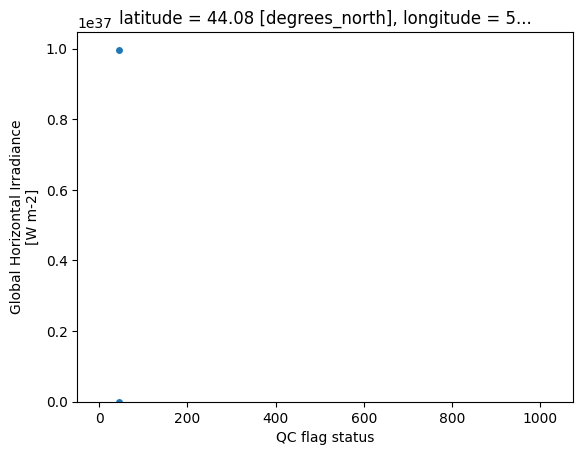

In [32]:
plt.show()